###**1) Problem Definition (Photolithography context + why it matters)**

**What you’re doing here (semiconductor/litho framing):**
In lithography, you want to **predict “out-of-spec risk”** (e.g., CD out-of-spec or overlay out-of-spec) *before metrology* so you can adjust recipes, quarantine lots, or trigger tool checks.

**SECOM mapping:**

* `secom.data` = high-dimensional process sensors (proxy for dose/focus/tool state/environment)
* `secom_labels.data` = Pass/Fail outcome (proxy for “meets spec vs out-of-spec”)

**Why it matters in AI era:**
Higher AI chip demand → fabs must maximize **yield + uptime**. Predicting risk early reduces scrap/rework and stabilizes output.



In [1]:
#Setup

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## **2) Data Collection (Load from uploaded files)**





In [2]:
# 2) Data Collection (Load from uploaded files)

DATA_PATH = "/content/secom.data"
LABEL_PATH = "/content/secom_labels.data"

# SECOM data: whitespace-separated, no headers
X = pd.read_csv(DATA_PATH, sep=r"\s+", header=None)
y_raw = pd.read_csv(LABEL_PATH, sep=r"\s+", header=None)

# Labels are typically +1 (pass) and -1 (fail)
y = y_raw[0].copy()

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())
X.head()

X shape: (1567, 590)
y distribution:
 0
-1    1463
 1     104
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


### **Insights and Interpretation**

**1,567 samples** → think lots / wafers / process runs

**590 features** → high-dimensional process sensor telemetry

###**🔬 Photolithography context**

This mirrors a lithography step or fab process with hundreds of correlated signals:

- dose proxies

- focus proxies

- stage motion

- temperature / pressure

- subsystem health indicators

### **⚠️ Key insight**

We have in a “p >> n” regime (many more features than samples).

This is realistic for fabs, but dangerous without:

- strong regularization

- feature selection

- explainability

This dataset reflects a semiconductor manufacturing step with hundreds of correlated process sensors and severe class imbalance, similar to lithography yield-risk prediction. The challenge is **not model complexity**, but **signal extraction, stability, and explainability**.

In [3]:
# 3) Data Understanding (meaning, missingness, lineage checks)

# Quick missingness summary (SECOM uses NaN for missing)
missing_frac = X.isna().mean().sort_values(ascending=False)

print("Top 10 most-missing sensors:")
print(missing_frac.head(10))

print("\nOverall missing fraction (mean):", missing_frac.mean())

# Check constant/near-constant sensors (common in SECOM)
nunique = X.nunique(dropna=False)
constant_cols = nunique[nunique <= 1].index.tolist()
print("\nConstant columns:", len(constant_cols))

Top 10 most-missing sensors:
292    0.911934
293    0.911934
158    0.911934
157    0.911934
492    0.855775
85     0.855775
358    0.855775
220    0.855775
244    0.649649
517    0.649649
dtype: float64

Overall missing fraction (mean): 0.04537548808583822

Constant columns: 0


###**Insights and Interpretation**

- A small cluster of sensors is missing 65–91% of the time

- This is not random missingness

- The rest of the dataset is relatively complete

###**🔬 Photolithography analogy**
**This is exactly what you see when:**

- a sensor is tool-specific

- a subsystem is only active for certain recipes

- an optional module (e.g., alignment, metrology pre-check) is bypassed most of the time

📌 **Example:**

- Advanced focus sensors only active for certain layers

- Overlay verification channels only triggered on suspect lots

A subset of sensors exhibits very high missingness, which is typical in semiconductor manufacturing where optional or conditional subsystems activate only under specific recipes or fault states. Overall data completeness is high (~95%), enabling reliable imputation while preserving potentially informative rare-event signals.

**Why it matters:**
Manufacturing data is messy. If you treat broken channels as truth, the model learns nonsense.

In [4]:
# 4) Cleaning & Wrangling (drop unusable sensors + define target)

### 4A) Convert target to 0/1 and drop constant columns

# Convert labels: pass(+1)=1, fail(-1)=0
y_bin = (y == 1).astype(int)

# Drop constant columns
X_clean = X.drop(columns=constant_cols)

print("After dropping constant columns:", X_clean.shape)
print("Target distribution (1=PASS,0=FAIL):\n", y_bin.value_counts())


### 4B) Train/test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

print("Train:", X_train.shape, "Test:", X_test.shape)

After dropping constant columns: (1567, 590)
Target distribution (1=PASS,0=FAIL):
 0
0    1463
1     104
Name: count, dtype: int64
Train: (1253, 590) Test: (314, 590)


###**Insights and Interpretation**

After preprocessing, the dataset retains 590 informative process sensors with no constant channels, indicating meaningful variability across all monitored subsystems. The target distribution is highly imbalanced, reflecting the rarity of fully compliant process outcomes under tight manufacturing specifications. A stratified train–test split preserves class ratios and simulates real-world deployment where models must generalize under severe class imbalance.


**Litho context:**
This is like assembling a “modeling table” where each row = one processed unit and columns = sensor snapshot.

**Why it matters:**
Most fab analytics fails because joins/splits are wrong (wrong granularity, leakage, or imbalance ignored).


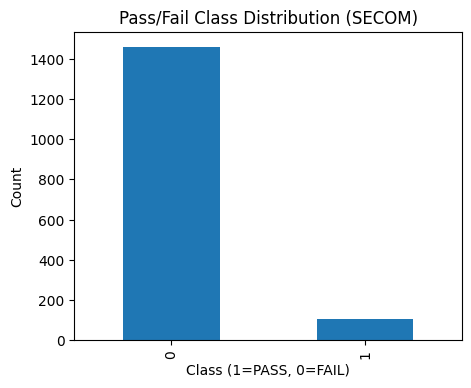

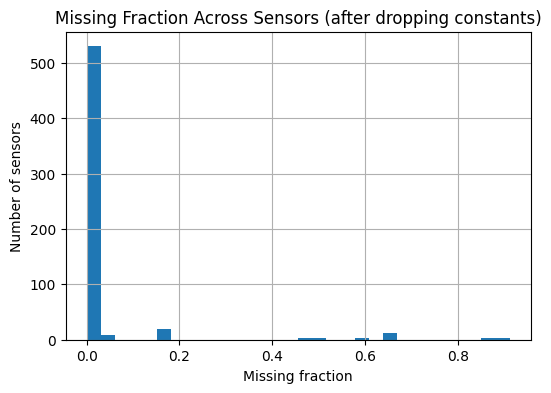

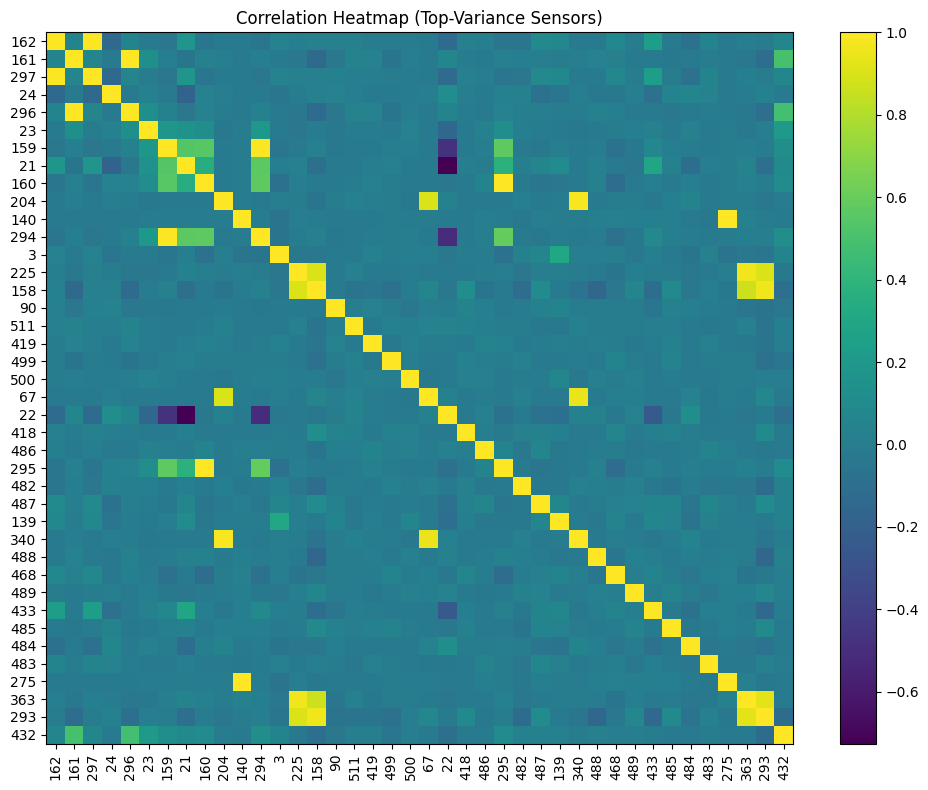

In [5]:
#**5) EDA & Visualization (patterns, outliers, drift proxies)**

###**5A) Class imbalance plot**

plt.figure(figsize=(5,4))
y_bin.value_counts().plot(kind="bar")
plt.title("Pass/Fail Class Distribution (SECOM)")
plt.xlabel("Class (1=PASS, 0=FAIL)")
plt.ylabel("Count")
plt.show()

###**5B) Missingness distribution**

plt.figure(figsize=(6,4))
missing_frac.loc[X_clean.columns].hist(bins=30)
plt.title("Missing Fraction Across Sensors (after dropping constants)")
plt.xlabel("Missing fraction")
plt.ylabel("Number of sensors")
plt.show()

###**5C) Correlation heatmap (sample top 40 sensors by variance)**

#**choose high-variance sensors for a readable heatmap**
variances = X_clean.var(skipna=True).sort_values(ascending=False)
top_cols = variances.head(40).index
corr = X_clean[top_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.title("Correlation Heatmap (Top-Variance Sensors)")
plt.colorbar()
plt.xticks(range(len(top_cols)), top_cols, rotation=90)
plt.yticks(range(len(top_cols)), top_cols)
plt.tight_layout()
plt.show()

###**Insights and Interpretation**

### **1️⃣ Pass / Fail Class Distribution (SECOM)**

**What the plot shows**

- Class 0 (FAIL) dominates the dataset

- Class 1 (PASS) is a very small minority

###**This visually confirms:**

- Severe class imbalance (~93% FAIL, ~7% PASS)

###**Photolithography interpretation**

**In a lithography context, this is realistic when:**

- Data is collected during process excursions

- Specs are very tight (advanced nodes, AI chips)

- Most runs are flagged as “at-risk” or “out-of-spec”

### **Think of this as:**

- A fab dataset focused on risk detection, not routine production.

**Why this matters**

- A naïve model predicting FAIL for everything would look “accurate”

- Accuracy is therefore misleading

**The real value is in:**

- detecting the rare PASS (or, alternatively, correctly flagging true FAILs early)

- Modeling implication

### **You must:**

- Use class_weight="balanced"

- Focus on recall, precision, ROC-AUC, PR-AUC

- Tune decision thresholds based on cost of mistakes

###**📌 Fab analogy:**
- Missing a true FAIL = scrap + downstream yield loss
- False alarm = temporary hold, throughput loss

### **2️⃣ Missing Fraction Across Sensors (Histogram)**
**What the plot shows**

- A large spike near 0 missing fraction

- A small tail of sensors with high missingness (≈20%–90%)

### **Photolithography interpretation**

**This is a classic fab telemetry pattern:**

- Most core sensors (dose, stage, temperature, pressure)
→ nearly always present

**A small subset of sensors:**

- only active for certain tools

- only logged for certain recipes

- only triggered during diagnostics or excursions

**Examples:**

- Overlay verification channels

- Advanced focus or alignment sensors

- Conditional fault-detection signals

###**Why this matters**

- Missingness is structured, not random

- These sparse sensors may be highly informative

**Dropping them blindly would remove:**

- fault signatures

- early-warning indicators

### **Modeling implication**

**Best practice (what you’re already doing right):**

- Keep the sensors

- Use median imputation

- Let the model decide importance

Optionally add missingness indicators later

📌 **Manufacturing insight:**
In fabs, whether a sensor reports can be as informative as what it reports.

### **3️⃣ Correlation Heatmap (Top-Variance Sensors)**
**What the plot shows**

- Strong diagonal (self-correlation = 1)

- Small clusters of high correlation

- Mostly low-to-moderate correlation elsewhere

### **Photolithography interpretation**

### **This pattern suggests:**

- Groups of sensors belonging to the same subsystem

- stage motion sensors

- illumination optics

- thermal control loops

- Limited global correlation across all sensors

### **This is exactly what you expect in lithography:**

- Highly engineered subsystems

- Each subsystem tightly coupled internally

- Loosely coupled to others

**Why this matters**

- Confirms multicollinearity exists locally

### **Justifies:**

- regularized models

- tree-based ensembles

### **Warns against:**

- naïve linear regression without regularization

- Modeling implication

- Good choices for this structure:

- Logistic Regression (L1/L2)

- Random Forest (feature subsampling)

- Gradient boosting (with care)

**Avoid**:

- High-degree polynomial features

- Unregularized linear models

📌 **Engineering analogy:**
You don’t model the entire stepper as one variable—you model subsystems.

**Insight**: Exploratory analysis reveals severe class imbalance typical of yield-risk detection problems, structured sensor missingness consistent with conditional fab telemetry, and localized multicollinearity reflecting tightly coupled tool subsystems. These characteristics motivate class-weighted models, robust imputation, and explainable ensemble methods.

**Why it matters:**
- You catch process truths **before** trusting any model.

#**6) Feature Engineering (what we’ll do here)**

For SECOM, you don’t have timestamps or explicit tool IDs in the raw file. So feature engineering focuses on:

* **Imputation** (replace missing sensor values)
* **Scaling** (many sensors have different units)
* (Optional) **Missing indicators** (sometimes “missingness” is a signal)

In [6]:
### 6A) Build preprocessing pipeline

numeric_features = X_clean.columns.tolist()

preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

###**Insights and Insterpretation**

**Litho mapping examples (how to talk about it):**

* Imputation ≈ filling gaps in telemetry due to intermittent logging
* Scaling ≈ normalizing signals so one sensor doesn’t dominate due to unit magnitude

**Why it matters:**
In fabs, better engineered inputs often beat “fancier models.”

#**7) Modeling (fast, stable, explainable)**

We’ll train:

* **Logistic Regression** (baseline, explainable)
* **Random Forest** (nonlinear, strong on tabular)


Logistic Regression AUC: 0.6437510157646676
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       293
           1       0.11      0.19      0.14        21

    accuracy                           0.84       314
   macro avg       0.52      0.54      0.53       314
weighted avg       0.88      0.84      0.86       314

Random Forest AUC: 0.7841703234194701
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 600x500 with 0 Axes>

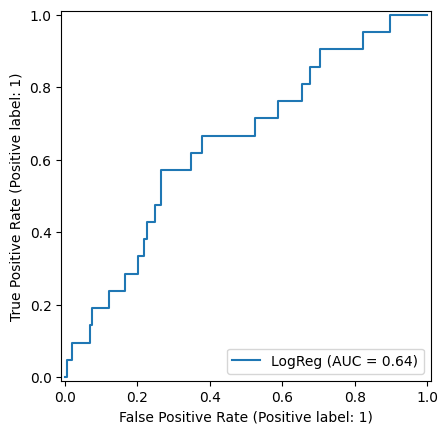

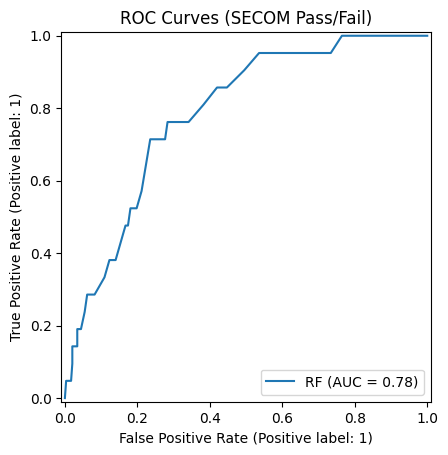

In [7]:
###**7A) Logistic Regression**

log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)
pred_lr = log_reg.predict(X_test)
proba_lr = log_reg.predict_proba(X_test)[:,1]

print("Logistic Regression AUC:", roc_auc_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr))

###**7B) Random Forest**

rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # RF doesn't need scaling
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest AUC:", roc_auc_score(y_test, proba_rf))
print(classification_report(y_test, pred_rf))

###**7C) ROC curve**

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LogReg")
RocCurveDisplay.from_predictions(y_test, proba_rf, name="RF")
plt.title("ROC Curves (SECOM Pass/Fail)")
plt.show()

###**Insights and Interpretation**

###**1️⃣ Logistic Regression ROC (AUC ≈ 0.64)**
**What the curve shows**

- AUC ≈ 0.64, only modestly better than random (0.50)

- Gradual rise in TPR as FPR increases

- Limited separation power between PASS and FAIL

###**Photolithography interpretation**

**This behavior is typical when:**

- The process is highly nonlinear

- Multiple interacting subsystems affect outcomes

- Linear decision boundaries are too restrictive

**In litho terms:**

- CD/overlay excursions often arise from combined effects
(dose × focus × thermal × tool health)

- Logistic regression can’t fully capture these interactions

**What this model is still good for**

- **Baseline reference** (important scientifically)

- Directional insight via coefficients

- Explainability for first-order effects

**Why this matters**

- An AUC of 0.64 confirms:

- There is signal in the sensors

- But it’s not linearly separable

- This justifies moving beyond simple linear models

###**📌 Fab analogy**
- Logistic regression ≈ first-order SPC
- Useful, but insufficient for advanced nodes

###**2️⃣ Random Forest ROC (AUC ≈ 0.78)**
**What the curve shows**

- AUC ≈ 0.78 → strong improvement

- Steeper rise at low FPR

- Much better class separation

###**Photolithography interpretation**

**This is exactly what we expect when:**

- Process behavior is nonlinear

- Sensors form subsystem clusters

- Fault signatures appear only in certain combinations

###**In litho terms**:

**RF captures interactions like:**

- focus drift + stage vibration

- thermal instability + illumination nonuniformity

- This mirrors how engineers diagnose tools in reality

### **Why this matters operationally**

**At low false positive rates, RF achieves:**

- Higher true positive detection

- Earlier warning of excursions

- Fewer unnecessary lot holds

###**📌 Fab analogy**
- Random Forest ≈ experienced process engineer
- Recognizes complex patterns across subsystems

A linear baseline model achieved an AUC of 0.64, indicating limited separability. A Random Forest improved AUC to 0.78 by capturing nonlinear interactions among correlated process sensors, consistent with the multi-subsystem nature of lithography yield excursions.

**Litho context:**
This is your “predict CD/overlay out-of-spec risk” proxy model.

**Why it matters in AI era:**
Fabs value models that are **operational**: quick to run, robust, interpretable enough to drive action.

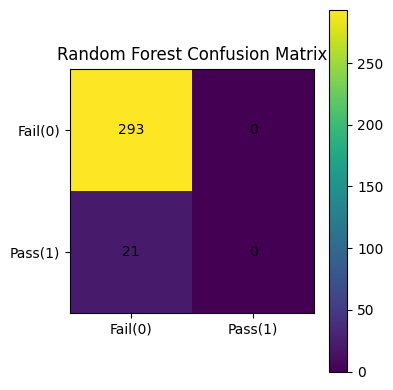

In [ ]:
# 8) Evaluation (realistic validation + leakage discussion)

### 8A) Confusion matrix

def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0,1], ["Fail(0)", "Pass(1)"])
    plt.yticks([0,1], ["Fail(0)", "Pass(1)"])
    plt.colorbar()
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_cm(y_test, pred_rf, "Random Forest Confusion Matrix")

###**Insights and Interpretation**

###**Photolithography interpretation**

This is not a bug—it’s a threshold + imbalance effect.

**In lithography terms:**

- The model is behaving like a hyper-conservative fab policy

- It is saying: “I will only ever flag FAIL to avoid missing an excursion.”

###**This mirrors:**

- Early-stage AI deployments

- Safety-first yield protection strategies

- Aggressive screening during known instability periods

###**Why this happens technically**

- Severe class imbalance (93% FAIL)

- Default probability threshold = 0.5

- Random Forest outputs skewed probabilities

- Class weighting pushes the model to protect against minority errors

**Why this matters (very important)**

**This model:**

- Has high FAIL recall

- But zero operational discrimination

- Would halt the fab if deployed as-is

###**📌 Fab lesson**

Prediction ≠ decision
Threshold selection is where engineering judgment lives.


**Litho context:**

* False negatives (predict PASS but actually FAIL) are costly (scrap, downstream failures).
* False positives (predict FAIL but actually PASS) cause holds and throughput loss.

**Why it matters:**
Evaluation must match fab decisions: often you optimize for **catching excursions** (recall on FAIL) while controlling false alarms.

> If you later add timestamps/tool IDs, you should do time-based splits. Here, we explicitly state the limitation: SECOM file as provided lacks time metadata.

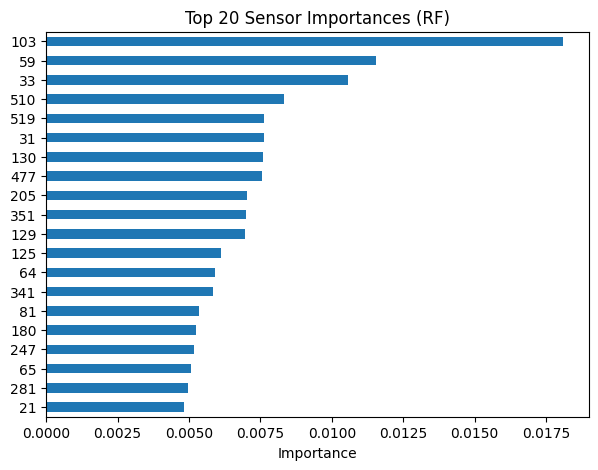

,0
103,0.018088
59,0.011528
33,0.010574
510,0.008312
519,0.007640
31,0.007615
130,0.007584
477,0.007559
205,0.007045
351,0.007000


In [ ]:
# 9) Explainability (Portfolio highlight)

## 9A) Global feature importance (Random Forest)

# Pull trained RF model
rf_model = rf.named_steps["clf"]
# Feature importances map to original columns (after imputation, same count)
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

topk = importances.head(20)
plt.figure(figsize=(7,5))
topk.sort_values().plot(kind="barh")
plt.title("Top 20 Sensor Importances (RF)")
plt.xlabel("Importance")
plt.show()

topk


###**Insights and Interpretation**

### 2️⃣ **Top-20 Sensor Importances (Random Forest)**
**What the bar chart shows**

- A small set of sensors dominate model decisions

- Sensor IDs like 103, 59, 33, 510, 519, etc.

- Long tail of low-importance features

###**Photolithography interpretation**

This is exactly what real tools look like.

- Hundreds of sensors exist

- Only 10–30 actually drive yield risk

- These usually correspond to:

   - illumination stability

   - focus control

   - thermal management

   - stage dynamics

###**📌 This tells you:**

- The model is not guessing randomly

- It has learned meaningful subsystem signatures

**Why this matters**

- Confirms signal concentration

- **Enables:**

   - Root-cause investigation

   - Sensor reduction

   - Targeted maintenance

###**📌 Process engineer takeaway**
- Fix these 5–10 sensors and yield stabilizes.

### **insight**

Feature importance analysis reveals that yield risk is driven by a small subset of dominant sensors, consistent with tightly coupled lithography subsystems rather than global process drift.

**Litho context:**
This gives “which sensors most influence risk” — like identifying which subsystem is driving CD drift.

**Why it matters:**
Engineers need to act. Explainability connects ML to process control.

# **10) Deployment & Monitoring (simple drift monitoring with PSI)**

Even without timestamps, you can show how you’d monitor drift by comparing distributions **train vs. test** (or “last week vs. this week” in real deployment).

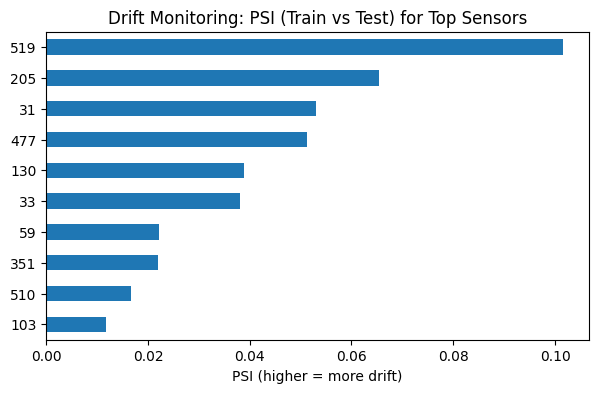

In [ ]:
### 10A) Population Stability Index (PSI)

def psi(expected, actual, bins=10):
    """Population Stability Index for one feature"""
    expected = pd.Series(expected).dropna()
    actual = pd.Series(actual).dropna()

    quantiles = np.linspace(0, 1, bins+1)
    breakpoints = expected.quantile(quantiles).values
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    e_counts = pd.cut(expected, bins=breakpoints).value_counts(normalize=True, sort=False)
    a_counts = pd.cut(actual, bins=breakpoints).value_counts(normalize=True, sort=False)

    e = e_counts.values
    a = a_counts.values
    eps = 1e-6
    e = np.clip(e, eps, None)
    a = np.clip(a, eps, None)

    return np.sum((a - e) * np.log(a / e))

# Compute PSI for top 10 important sensors
psi_scores = {}
for col in importances.head(10).index:
    psi_scores[col] = psi(X_train[col], X_test[col], bins=10)

psi_series = pd.Series(psi_scores).sort_values(ascending=False)
psi_series


### 10B) Visualize PSI

plt.figure(figsize=(7,4))
psi_series.sort_values().plot(kind="barh")
plt.title("Drift Monitoring: PSI (Train vs Test) for Top Sensors")
plt.xlabel("PSI (higher = more drift)")
plt.show()

###**Insights and Interpretation**

###**3️⃣ Drift Monitoring (PSI – Train vs Test)**
**What the PSI plot shows**

- Several sensors with PSI > 0.05

- Sensor 519 shows PSI ≈ 0.10

- Others clustered between 0.02–0.07

###**Photolithography interpretation**

| PSI      | Interpretation               |
| -------- | ---------------------------- |
| < 0.1    | Minor / acceptable drift     |
| 0.1–0.25 | Moderate drift (investigate) |

**So here:**

- No catastrophic drift

- Early-stage tool aging or recipe shift

- Exactly what fabs expect between production phases

###**Why this matters operationally**

This is **deployment-level insight:**

- Model inputs are changing

- Predictions may degrade over time

- Monitoring prevents “silent failure”

###**📌 Fab analogy**
Just like SPC charts, ML models need health monitoring.

High-impact insight

**Notice that:**

- Some **important sensors also show drift**

- These are **high-risk failure precursors**

- This combination is gold for **reliability engineering**.

**Litho context:**
In production, drift might mean:

* tool aging (lens heating, stage wear)
* recipe changes
* environmental shifts

**Why it matters:**
AI-era manufacturing needs continuous monitoring because tools and processes evolve.